Hourly Demand Forecast V2.1.1
--

V1.0
  - From daily demand forecast to hourly demand forecast, use different hourly distributions for each weekday.
  - Thanksgiving day and X-mas Eve hourly distributions are different.
  - Use hourly distributions of deliveries.
  
V2.0
  - Use hourly distributions including hourly ld + deliveries.
  
V2.1
  - Get weekday/hour distribution for 6, 7 and 8 as one group and the rest months as another group.
  
V2.1.1
  - In addition to V2.1, get the distribution into more groups.
    - 6, 7, 8
    - 9, 10
    - 11, 12, 1, 2
    - 3, 4, 5

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
city = 'SF'
file_lost = '../' + city + '_Baseline/20180601_20190531 ' + city + ' Lost Deliveries.csv'
file_forecast = '../' + city + '_Baseline/20180601_20190531 ' + city + ' Daily Forecasts.csv'
file_deliveries = '../' + city + '_Baseline/20180601_20190531 ' + city + ' Deliveries.csv'
file_national_deliveries = '../SF_Baseline/20190601_20190531 National Deliveries.csv'

In [3]:
# Read in daily forecast and get date.

daily_forecasts = pd.read_csv(file_forecast)
daily_forecasts.rename(columns={i:i.lower() for i in daily_forecasts.columns.tolist()}, inplace=True)
daily_forecasts.sort_values(by=['date'], inplace=True)

daily_forecasts['date'] = pd.to_datetime(daily_forecasts['date'], infer_datetime_format=True)
daily_forecasts['date'] = daily_forecasts['date'].map(lambda x: x.date())

In [4]:
daily_forecasts.head(3)

,zone_id,date,forecast_date,demand,created_pt
319,1,2018-06-01,2018-05-31,2036.66,2018-05-31 00:45:00.000 -0700
320,1,2018-06-02,2018-06-01,2074.29,2018-06-01 00:47:00.000 -0700
321,1,2018-06-03,2018-06-02,2786.70,2018-06-02 00:47:00.000 -0700


In [5]:
# Read in deliveries

deliveries = pd.read_csv(file_deliveries)
deliveries.rename(columns={i:i.lower() for i in deliveries.columns.tolist()}, inplace=True)

national_deliveries = pd.read_csv(file_national_deliveries)
national_deliveries.rename(columns={i:i.lower() for i in national_deliveries.columns.tolist()},
                           inplace=True)

In [6]:
national_deliveries['date'] = pd.to_datetime(national_deliveries['date'], infer_datetime_format=True)
national_deliveries['date'] = national_deliveries['date'].map(lambda x: x.date())
national_deliveries = national_deliveries[(national_deliveries['date'] >= datetime(2018,6,1).date())\
                                        & (national_deliveries['date'] <= datetime(2019,5,31).date())]

In [7]:
# Get date and date_hour

deliveries['windown_start_at'] = deliveries['windown_start_at'].map(lambda x: str(x)[:19])
deliveries['windown_start_at'] = pd.to_datetime(deliveries['windown_start_at'], infer_datetime_format=True)
deliveries['window_start_hour'] = deliveries['windown_start_at']\
        .map(lambda x: datetime(x.year, x.month, x.day, x.hour, 0, 0))

deliveries['date'] = deliveries['windown_start_at']\
        .map(lambda x: x.date())

# Fix an issue
deliveries = deliveries[deliveries['date'] >= datetime(2018,6,1).date()].copy()

In [8]:
deliveries.head(3)

,order_id,zone_id,warehouse_id,windown_start_at,window_start_hour,date
0,266429695,1,105,2018-07-07 14:58:00,2018-07-07 14:00:00,2018-07-07
1,266425268,1,3,2018-07-07 16:00:00,2018-07-07 16:00:00,2018-07-07
2,266429872,1,3,2018-07-07 15:00:00,2018-07-07 15:00:00,2018-07-07


In [9]:
daily_deliveries = deliveries[['date', 'order_id']]\
    .groupby(['date']).count().reset_index().rename(columns={'order_id':'deliveries_daily'})


hourly_deliveries = deliveries[['window_start_hour', 'order_id']]\
    .groupby(['window_start_hour']).count().reset_index().rename(columns={'order_id':'deliveries_hourly'})

In [10]:
# Read in lost deliveries

ld = pd.read_csv(file_lost)
ld.rename(columns={i:i.lower() for i in ld.columns.tolist()}, inplace=True)

ld['date'] = pd.to_datetime(ld['date'], infer_datetime_format=True)
ld['date'] = ld['date'].map(lambda x: x.date())

# Get daily Lost deliveries
daily_ld = ld[['date', 'lost']].groupby(['date']).sum().reset_index().rename(columns={'lost':'lost_daily'})

In [11]:
ld.head(3)

,zone_id,date,hour,lost
0,1,2018-06-01,0,3.477067
1,1,2018-06-01,1,0.818058
2,1,2018-06-01,2,1.420469


In [12]:
# Get daily demand

daily_demand = daily_deliveries.merge(daily_ld, on='date')
daily_demand = daily_demand.merge(daily_forecasts[['date', 'demand']].rename(columns={'demand':'forecast'}),
                                 on=['date'])
daily_demand['demand'] = daily_demand['deliveries_daily'] + daily_demand['lost_daily'] 

daily_demand.head(3)

,date,deliveries_daily,lost_daily,forecast,demand
0,2018-06-01,2016,87.653313,2036.66,2103.653313
1,2018-06-02,1886,65.057823,2074.29,1951.057823
2,2018-06-03,2498,141.792444,2786.70,2639.792444


In [13]:
# Get the APE

daily_demand['ape'] = (daily_demand['forecast'] - daily_demand['demand']) / daily_demand['demand']
daily_demand['ape_abs'] = daily_demand['ape'].map(lambda x: abs(x))

# Get MAPE
daily_demand['month'] = daily_demand['date'].map(lambda x: x.month)
daily_demand_mape = daily_demand[['month', 'ape_abs']]\
    .groupby(['month']).mean().reset_index().rename(columns={'ape_abs':'mape'})

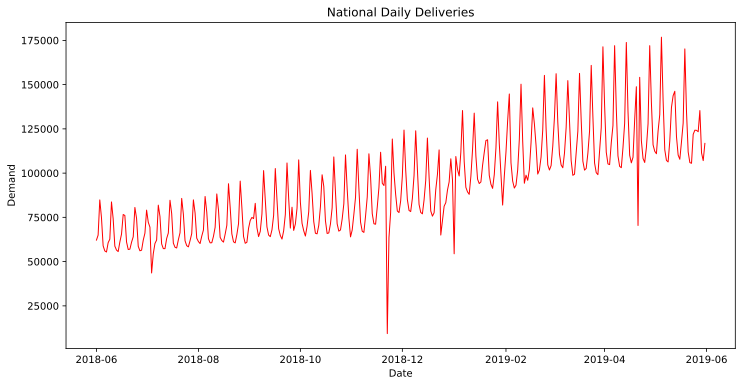

In [14]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(national_deliveries['date'],
         national_deliveries['deliveries'], color='red', linewidth=1)
ax1.set_ylabel('Demand')
ax1.set_xlabel('Date')
ax1.set_title('National Daily Deliveries')
plt.show()

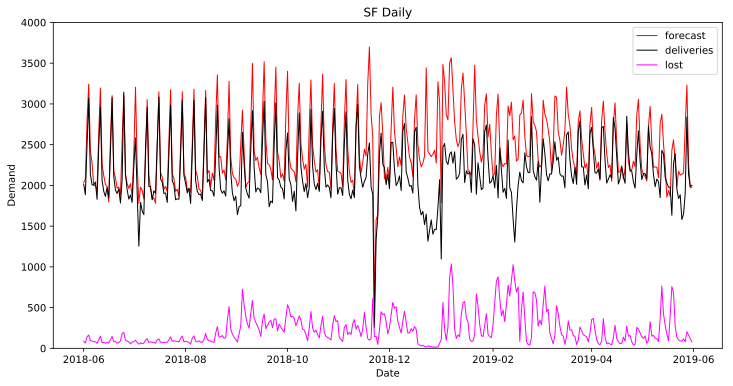

In [15]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(daily_demand['date'],
         daily_demand['forecast'], color='red', linewidth=1)
ax1.plot(daily_demand['date'],
         daily_demand['deliveries_daily'], color='black', linewidth=1)
ax1.plot(daily_demand['date'],
         daily_demand['lost_daily'], color='magenta', linewidth=1)
ax1.set_ylabel('Demand')
ax1.set_xlabel('Date')
ax1.set_ylim([0, 4000])
ax1.legend(['forecast', 'deliveries', 'lost'])
ax1.set_title(city + ' Daily')
plt.show()

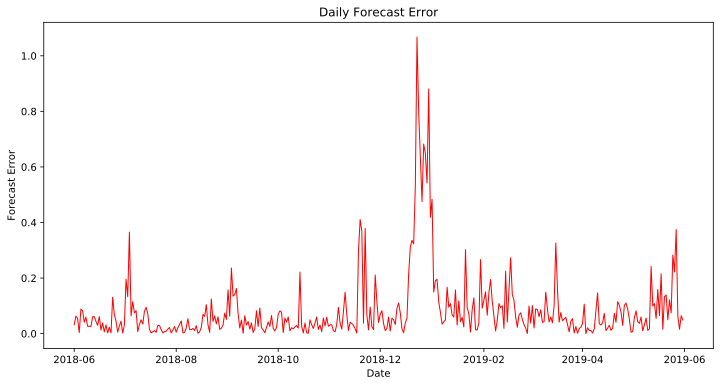

In [16]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(daily_demand['date'],
         daily_demand['ape_abs'], color='red', linewidth=1)
ax1.set_ylabel('Forecast Error')
ax1.set_xlabel('Date')
ax1.set_title('Daily Forecast Error')
plt.show()

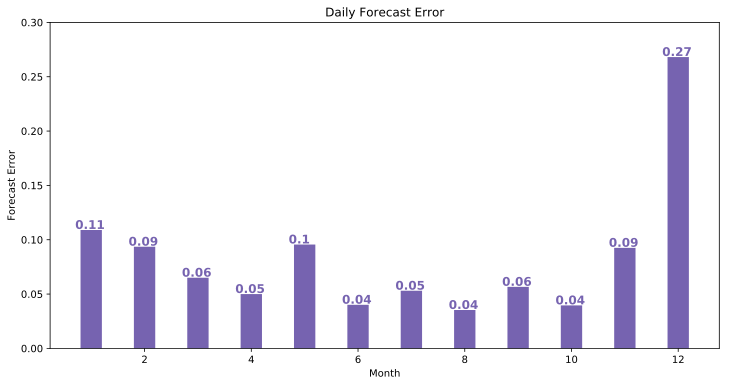

In [17]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.bar(daily_demand_mape['month'],
         daily_demand_mape['mape'], align='center', color='#7663b0', width=0.4)
ax1.set_ylabel('Forecast Error')
ax1.set_xlabel('Month')
ax1.set_ylim([0, 0.3])
for i, v in enumerate(daily_demand_mape['mape']):
    ax1.text(i + 0.7, v + 0.001, str(round(v, 2)),\
             color='#7663b0', fontweight='bold', fontsize=12)
ax1.set_title('Daily Forecast Error')
plt.show()

### Get the hourly demand distribution within one day

In [18]:
hourly_deliveries['date'] = hourly_deliveries['window_start_hour'].map(lambda x: x.date())
hourly_deliveries['hour'] = hourly_deliveries['window_start_hour'].map(lambda x: x.hour)

# Get hourly ld + deliveries
hourly_demand = ld[['date', 'hour', 'lost']].merge(hourly_deliveries[['date', 'hour', 'deliveries_hourly']],
                                                  on=['date', 'hour'], how='right')
hourly_demand['hourly_demand'] = hourly_demand['lost'] + hourly_demand['deliveries_hourly']

# Get hourly percentage
daily_temp = hourly_demand[['date', 'hourly_demand']].groupby('date').sum()\
        .reset_index().rename(columns={'hourly_demand':'daily_demand'})
hourly_demand = hourly_demand.merge(daily_temp, on=['date'])
hourly_demand['percent'] = hourly_demand['hourly_demand'] / hourly_demand['daily_demand']

In [19]:
hourly_demand.head(3)

,date,hour,lost,deliveries_hourly,hourly_demand,daily_demand,percent
0,2018-06-01,7,10.135089,19,29.135089,2087.109221,0.013960
1,2018-06-01,8,4.854578,59,63.854578,2087.109221,0.030595
2,2018-06-01,9,7.055406,120,127.055406,2087.109221,0.060876


In [20]:
# Get the hourly distribution for two groups.
# 1. 6, 7 and 8 months
# 2. The other months

hourly_demand['weekday'] = hourly_demand['date'].map(lambda x: x.weekday())
hourly_demand['month'] = hourly_demand['date'].map(lambda x: x.month)
hourly_demand['group'] = hourly_demand['month'].map(lambda x: 1 if x in [6,7,8] 
                                                         else 2 if x in [9, 10]
                                                         else 3 if x in [11, 12, 1, 2]
                                                         else 4)

df_avgs = hourly_demand[['group', 'weekday', 'hour', 'percent']]\
        .groupby(['group', 'weekday', 'hour']).mean().reset_index().rename(columns={'percent':'mean'})

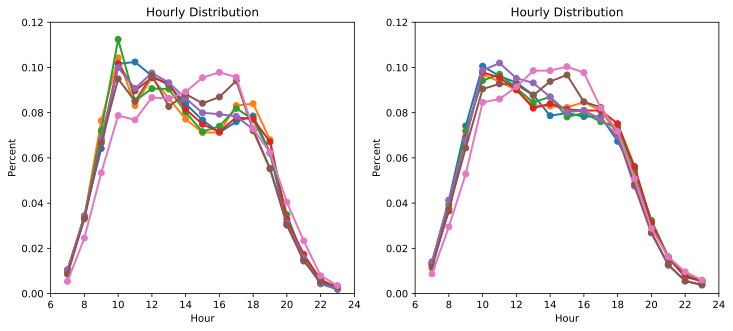

In [21]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)  
for i in range(7):
    df_avgs.sort_values(by=['group', 'weekday', 'hour'], inplace=True)
    ax1.plot(df_avgs[(df_avgs['weekday'] == i) & (df_avgs['group'] == 1)]['hour'],
         df_avgs[(df_avgs['weekday'] == i) & (df_avgs['group'] == 1)]['mean'], 'o-', linewidth=2)
    
# Compare some special days    
if False:
    ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2019, 4, 21).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2019, 4, 21).date()]['percent'],
        'b-', linewidth=3)
ax1.set_ylabel('Percent')
ax1.set_xlabel('Hour')
ax1.set_xlim([6, 24])
ax1.set_ylim([0, 0.12])
ax1.set_title('Hourly Distribution')

ax2 = fig.add_subplot(122)  
for i in range(7):
    df_avgs.sort_values(by=['group', 'weekday', 'hour'], inplace=True)
    ax2.plot(df_avgs[(df_avgs['weekday'] == i) & (df_avgs['group'] == 2)]['hour'],
         df_avgs[(df_avgs['weekday'] == i) & (df_avgs['group'] == 2)]['mean'], 'o-', linewidth=2)

ax2.set_ylabel('Percent')
ax2.set_xlabel('Hour')
ax2.set_xlim([6, 24])
ax2.set_ylim([0, 0.12])
ax2.set_title('Hourly Distribution')
plt.show()

### Special Days
  - Thanksgiving
  - X-mas Eve

#### Holiday but forecast is good
  - Easter
  
#### Error is high but distribution is not special
  - 1/1: New Year's Day, the original daily forecast error is high
  - 12/31: New Year's Eve, the original daily forecast error is high
  - 7/4: Independence Day, the original daily forecast error is high
  - 12/22: the original daily forecast error is high
  - 12/23: the original daily forecast error is high
  - 12/30: the original daily forecast error is high
  - 12/26: the original daily forecast error is high
  - 12/27: the original daily forecast error is high
  - 12/28: the original daily forecast error is high
  - 12/29: the original daily forecast error is high
  - 11/19: the original daily forecast error is high
  - 5/27: Memorial Day, the original daily forecast error is high
  - 11/20: the original daily forecast error is high
  - 12/20: the original daily forecast error is high
  - 5/25: the original daily forecast error is high
  - 1/21: the original daily forecast error is high
  - 6/24: the original daily forecast error is high

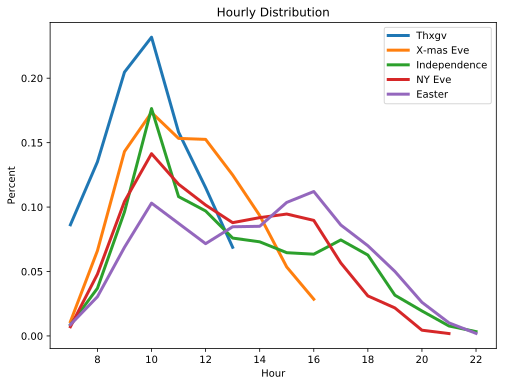

In [22]:
# For the special days.

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111) 
ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2018, 11, 22).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2018, 11, 22).date()]['percent'],
        linewidth=3, label='Thxgv')
ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2018,12,24).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2018,12,24).date()]['percent'],
        linewidth=3, label='X-mas Eve')
ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2018,7,4).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2018,7,4).date()]['percent'],
        linewidth=3, label='Independence')
ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2018, 12, 31).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2018, 12, 31).date()]['percent'],
        linewidth=3, label='NY Eve')
ax1.plot(hourly_demand[hourly_demand['date'] == datetime(2019, 4, 21).date()]['hour'],
        hourly_demand[hourly_demand['date'] == datetime(2019, 4, 21).date()]['percent'],
        linewidth=3, label='Easter')
ax1.set_ylabel('Percent')
ax1.set_xlabel('Hour')
ax1.legend()
ax1.set_title('Hourly Distribution')
plt.show()

### Distribution daily forecast into hourly forecast

In [23]:
hourly_demand.head(3)

,date,hour,lost,deliveries_hourly,hourly_demand,daily_demand,percent,weekday,month,group
0,2018-06-01,7,10.135089,19,29.135089,2087.109221,0.013960,4,6,1
1,2018-06-01,8,4.854578,59,63.854578,2087.109221,0.030595,4,6,1
2,2018-06-01,9,7.055406,120,127.055406,2087.109221,0.060876,4,6,1


In [24]:
daily_forecasts.head(3)

,zone_id,date,forecast_date,demand,created_pt
319,1,2018-06-01,2018-05-31,2036.66,2018-05-31 00:45:00.000 -0700
320,1,2018-06-02,2018-06-01,2074.29,2018-06-01 00:47:00.000 -0700
321,1,2018-06-03,2018-06-02,2786.70,2018-06-02 00:47:00.000 -0700


In [25]:
df_avgs.head(3)

,group,weekday,hour,mean
0,1,0,7,0.009417
1,1,0,8,0.034293
2,1,0,9,0.064141


In [26]:
# Prepare percent distribution

hourly_dist= hourly_demand[['group', 'weekday', 'hour', 'date']]\
    .merge(df_avgs[['group', 'weekday', 'hour', 'mean']], on=['group', 'weekday', 'hour'], how='outer')
hourly_dist.sort_values(by=['date','hour'], inplace=True)

# Merge distribubtion with daily forecast
hourly_forecast = hourly_dist.merge(daily_forecasts[['date', 'demand']], on='date')

# Get hourly forecasts
hourly_forecast['hourly_forecast'] = hourly_forecast['demand'] * hourly_forecast['mean']

In [27]:
# Get hourly demand and forecast together
hourly_demand = hourly_demand.merge(hourly_forecast[['date', 'hour', 'hourly_forecast']],
                                   on=['date', 'hour'])

# Get hourly error
hourly_demand['error'] = (hourly_demand['hourly_forecast'] - hourly_demand['hourly_demand'])\
            / hourly_demand['hourly_demand']
hourly_demand['error_abs'] = hourly_demand['error'].map(lambda x: abs(x))

# Get weighted error
hourly_demand['wape'] = hourly_demand['error_abs'] * hourly_demand['percent']
hourly_forecast_wape = hourly_demand[['date', 'wape']].groupby(['date']).sum().reset_index()

# Inspect
hourly_demand.head(3)

,date,hour,lost,deliveries_hourly,hourly_demand,daily_demand,percent,weekday,month,group,hourly_forecast,error,error_abs,wape
0,2018-06-01,7,10.135089,19,29.135089,2087.109221,0.013960,4,6,1,20.991565,-0.279509,0.279509,0.003902
1,2018-06-01,8,4.854578,59,63.854578,2087.109221,0.030595,4,6,1,70.173044,0.098951,0.098951,0.003027
2,2018-06-01,9,7.055406,120,127.055406,2087.109221,0.060876,4,6,1,138.787573,0.092339,0.092339,0.005621


#### Investigate the top error days

In [28]:
#hourly_demand[hourly_demand['date'] == datetime(2019, 4, 21).date()]

In [29]:
#hourly_forecast_wape[hourly_forecast_wape['date'] == datetime(2019, 4, 21).date()][['date', 'wape']]

In [30]:
# Get the worse days.

hourly_forecast_wape[['date', 'wape']].sort_values(by=['wape'], ascending=False).head(20)\
    .merge(daily_demand[['date', 'ape_abs']].sort_values(by=['ape_abs'], ascending=False).head(20), 
    on='date', how='outer')

,date,wape,ape_abs
0,2018-12-23,1.074471,1.067115
1,2018-12-30,0.881012,0.880794
2,2018-12-27,0.729633,0.682204
3,2018-12-28,0.642118,0.648045
4,2018-12-29,0.544892,0.541967
5,2018-12-22,0.532453,0.530563
6,2019-01-01,0.488877,0.483207
7,2018-12-26,0.471964,0.475361
8,2018-12-24,0.444355,0.798716
9,2018-11-19,0.429892,0.410669


In [31]:
# Get WMAPE
hourly_forecast_wape['month'] = hourly_forecast_wape['date'].map(lambda x: x.month)
hourly_forecast_wmape = hourly_forecast_wape[['month', 'wape']]\
    .groupby(['month']).mean().reset_index().rename(columns={'wape':'wmape'})

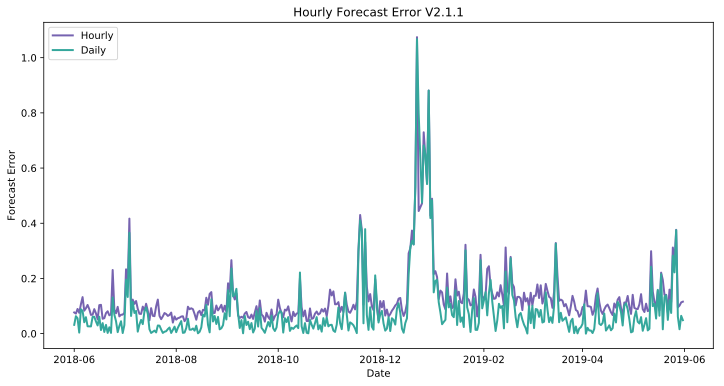

In [37]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(hourly_forecast_wape['date'],
         hourly_forecast_wape['wape'], color='#7663b0', linewidth=2, label='Hourly')
ax1.plot(daily_demand['date'],
         daily_demand['ape_abs'], color='#35a79c', linewidth=2, label='Daily')
ax1.set_ylabel('Forecast Error')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')
ax1.set_title('Hourly Forecast Error V2.1.1')
plt.show()

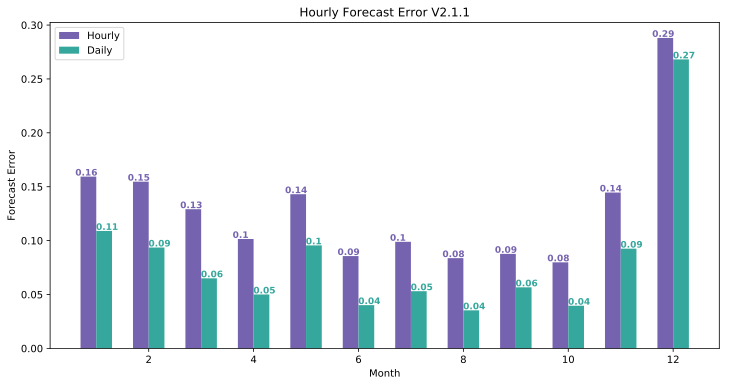

In [33]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.bar([i - 0.15 for i in hourly_forecast_wmape['month']],
         hourly_forecast_wmape['wmape'], align='center', color='#7663b0', width=0.3, label='Hourly')
ax1.bar([i + 0.15 for i in daily_demand_mape['month']],
         daily_demand_mape['mape'], align='center', color='#35a79c', width=0.3, label='Daily')
ax1.set_ylabel('Forecast Error')
ax1.set_xlabel('Month')
ax1.legend(loc='best')
#ax1.set_ylim([0, 0.35])
for i, v in enumerate(hourly_forecast_wmape['wmape']):
    ax1.text(i + 0.6, v + 0.001, str(round(v, 2)),\
             color='#7663b0', fontweight='bold', fontsize=9)
for i, v in enumerate(daily_demand_mape['mape']):
    ax1.text(i + 0.995, v + 0.001, str(round(v, 2)),\
             color='#35a79c', fontweight='bold', fontsize=9)
ax1.set_title('Hourly Forecast Error V2.1.1')
plt.show()

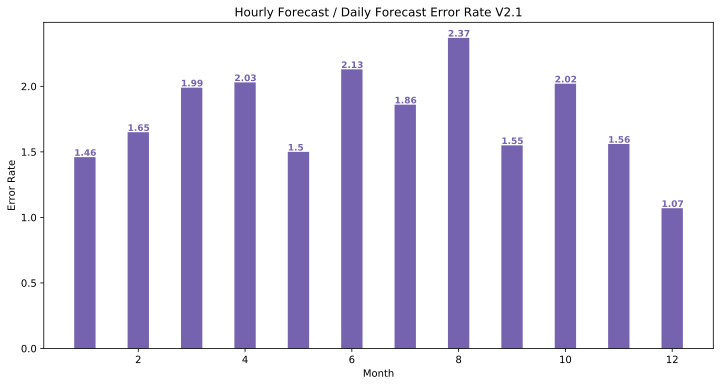

In [34]:
fig = plt.figure(figsize=(12, 6))

y = [round(i / j, 2) for i, j in zip(hourly_forecast_wmape['wmape'], daily_demand_mape['mape'])]

ax1 = fig.add_subplot(111)
ax1.bar(hourly_forecast_wmape['month'],
         y, align='center', color='#7663b0', width=0.4)
ax1.set_ylabel('Error Rate')
ax1.set_xlabel('Month')
for i, v in enumerate(y):
    ax1.text(i + 0.8, v + 0.01, str(round(v, 2)),\
             color='#7663b0', fontweight='bold', fontsize=9)
ax1.set_title('Hourly Forecast / Daily Forecast Error Rate V2.1')
plt.show()

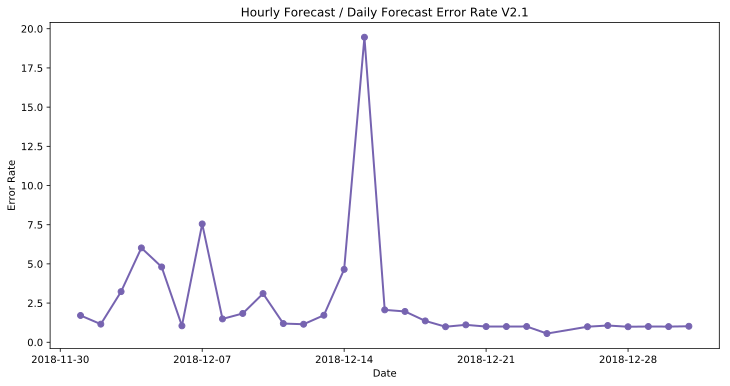

,date,wape,month,ape_abs,rate
22,2018-12-23,1.074471,12,1.067115,1.006893
28,2018-12-30,0.881012,12,0.880794,1.000247
25,2018-12-27,0.729633,12,0.682204,1.069522
26,2018-12-28,0.642118,12,0.648045,0.990854
27,2018-12-29,0.544892,12,0.541967,1.005398


In [35]:
month = 12

df_rate = hourly_forecast_wape[hourly_forecast_wape['month'] == month]\
    .merge(daily_demand[daily_demand['month'] == month][['date', 'ape_abs']], on='date')
df_rate['rate'] = df_rate['wape'] / df_rate['ape_abs']


fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(df_rate['date'], df_rate['rate'], 'o-', color='#7663b0', linewidth=2)
ax1.set_ylabel('Error Rate')
ax1.set_xlabel('Date')
if False:
    for i, v in enumerate(y):
        ax1.text(i + 0.8, v + 0.01, str(round(v, 2)),\
             color='#7663b0', fontweight='bold', fontsize=9)
ax1.set_title('Hourly Forecast / Daily Forecast Error Rate V2.1')
plt.show()

df_rate[df_rate['ape_abs'] >= 0.01].sort_values(by=['wape'], ascending=False).head(5)

In [36]:
hourly_demand[hourly_demand['date'] == datetime(2018, 12, 23).date()]

,date,hour,lost,deliveries_hourly,hourly_demand,daily_demand,percent,weekday,month,group,hourly_forecast,error,error_abs,wape
3368,2018-12-23,7,0.267783,10,10.267783,1665.108591,0.006166,6,12,3,24.528140,1.388845,1.388845,0.008564
3369,2018-12-23,8,0.607706,63,63.607706,1665.108591,0.038200,6,12,3,138.127212,1.171548,1.171548,0.044754
3370,2018-12-23,9,0.458717,139,139.458717,1665.108591,0.083754,6,12,3,258.628970,0.854520,0.854520,0.071569
3371,2018-12-23,10,1.041770,178,179.041770,1665.108591,0.107526,6,12,3,340.745113,0.903160,0.903160,0.097113
3372,2018-12-23,11,0.643747,139,139.643747,1665.108591,0.083865,6,12,3,314.508118,1.252218,1.252218,0.105017
3373,2018-12-23,12,0.549047,135,135.549047,1665.108591,0.081406,6,12,3,331.783135,1.447698,1.447698,0.117851
3374,2018-12-23,13,0.544831,167,167.544831,1665.108591,0.100621,6,12,3,327.487998,0.954629,0.954629,0.096056
3375,2018-12-23,14,0.444385,151,151.444385,1665.108591,0.090952,6,12,3,331.233967,1.187166,1.187166,0.107975
3376,2018-12-23,15,1.442315,173,174.442315,1665.108591,0.104763,6,12,3,326.292924,0.870492,0.870492,0.091196
3377,2018-12-23,16,1.558314,152,153.558314,1665.108591,0.092221,6,12,3,312.140610,1.032717,1.032717,0.095238
